## Neural Networks (2022-2023)
### Lab session 2: Convolutional neural networks

In [1]:
# We will use torchmetrics for computing the accuracy: https://torchmetrics.readthedocs.io/
%pip install torchmetrics --quiet

Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.backends import cudnn

In [2]:
import torchmetrics
import torchvision
from torchvision import transforms as T
import torchvision.transforms.functional as TF
from torchvision.models import resnet34, resnet18, ResNet34_Weights, ResNet18_Weights

In [3]:
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from composer.algorithms import CutMix
from composer.trainer import Trainer
import composer.functional as cf
import h5py

c:\Users\Gianmarco\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


## Step 1: Loading the data

For this lab session we will use KMNIST, which is a simple drop-in replacement for MNIST: http://codh.rois.ac.jp/kmnist/index.html.en. 
The input is a (28,28) black-and-white image, which has to be classified into 10 different classes.

In [4]:
train_data = torchvision.datasets.KMNIST('./data', train=True, download=True)

In [5]:
# A Dataset is fundamentally an iterator over the elements of the dataset.
# You can read more about its functionality here: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
len(train_data)

60000

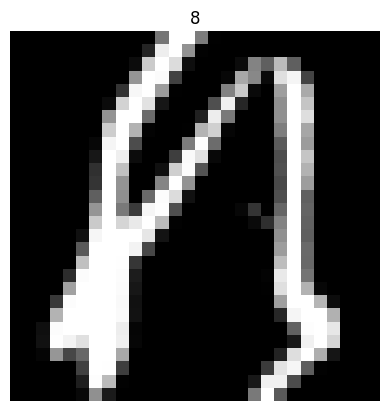

In [6]:
# Alternative way to get the first element: image, label = next(iter(train_data))
for image, label in train_data:
  plt.title(label)
  plt.axis("off")
  plt.imshow(image, cmap="gray")
  break

In [7]:
print(type(image))
print(F"{image.size[0]} x {image.size[1]}")
print(label)

<class 'PIL.Image.Image'>
28 x 28
8


## Step 2: Pre-processing the data

The simplest way to pre-process the input data (normalization, data augmentation, ...) is to define one or more transformations when instantiating the dataset: https://pytorch.org/vision/stable/transforms.html. 

In [8]:
# Simple transformation that converts the PIL image to a PyTorch array
T.ToTensor()(image).shape

torch.Size([1, 28, 28])

In [4]:
# T.Compose allows to chain together multiple transformations
train_transforms = T.Compose([
    T.RandomRotation(15),
    T.RandomAutocontrast(),
    T.ToTensor()
])

In [6]:
# This loads data with both data conversion & a simple data augmentation step.
train_data = torchvision.datasets.KMNIST('./data', train=True, transform=train_transforms)

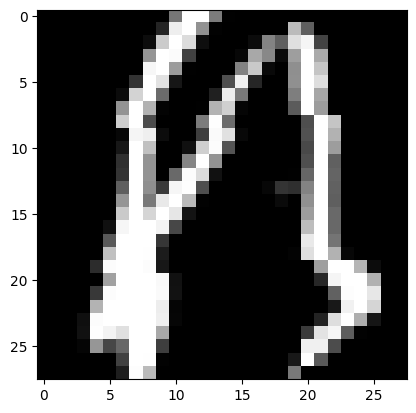

In [11]:
# Try this multiple times: we are loading the same image, but with a different
# rotation each time.
image, label = next(iter(train_data))
plt.imshow(image[0], cmap='gray')

In [7]:
# Loaders are used to shuffle, batch, and possibly sample the elements of the dataset
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

In [8]:
# A Batch
xb, yb = next(iter(train_loader))

In [10]:
# Shape is now (batch_size (samples), channels, height, width)
xb.shape

torch.Size([64, 1, 28, 28])

In [15]:
# Target shape is now (batch_size,)
yb

tensor([6, 4, 1, 1, 7, 6, 0, 2, 3, 9, 1, 1, 3, 4, 9, 6, 4, 1, 8, 9, 1, 8, 9, 6,
        6, 2, 2, 0, 6, 8, 9, 3, 5, 9, 3, 2, 3, 0, 9, 4, 8, 3, 7, 8, 2, 3, 2, 4,
        1, 0, 0, 0, 5, 5, 2, 8, 3, 8, 8, 7, 9, 3, 9, 1])

In [9]:
# Loading the test data is similar, but:
# (a) - We do not apply data augmentation,
# (b) - We do not shuffle when building the mini-batches.
test_data = torchvision.datasets.KMNIST('./data', train=False, transform=T.ToTensor())
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

## Interlude: Using layers in PyTorch

See the list of all available layers here: https://pytorch.org/docs/stable/nn.html.

In [5]:
# 1 input channel, 16 output channels, 5x5 kernel size
# Input channel corresponds on the channels of the image
#
#                  I x O x K, padding,  stride
conv2d = nn.Conv2d(1, 16, 5, padding=2, stride=2)

In [13]:
conv2d(xb).shape
# Batch_size (samples) = 64
# Output channels = 16
# Height = 14
# Width = 14

torch.Size([64, 16, 14, 14])

In [ ]:
# Pool size of 2x2
kernel_size = 2
nn.MaxPool2d(kernel_size=kernel_size)(xb).shape
# Batch_size (samples) = 64
# Output channels = 1
# Height = 14
# Width = 14

In [15]:
# parameters() returns a generator over parameters;
# named_parameters() returns a generator listing also the names of the parameters.
for n, p in conv2d.named_parameters():
  print(F"Name: {n} | Shape: {p.shape}")

Name: weight | Shape: torch.Size([16, 1, 5, 5])
Name: bias | Shape: torch.Size([16])


In [7]:
# 0.4 = Probability of ignoring nodes
dropout = nn.Dropout(0.4)

In [13]:
x = torch.randn((3, 2))

In [14]:
# Training mode: some data is dropped, the other values are rescaled (inverted dropout).
print(F"X before dropout: {x}")
dropout.train()
print("---------------------")
print(F"X after dropout: {dropout(x)}")

X before dropout: tensor([[ 1.3496, -0.5178],
        [ 0.0599, -0.7011],
        [ 0.0990,  1.0360]])
---------------------
X after dropout: tensor([[ 2.2494, -0.0000],
        [ 0.0998, -1.1685],
        [ 0.0000,  1.7267]])


In [15]:
# Evaluation mode: nothing happens.
dropout.eval()
dropout(x)

tensor([[ 1.3496, -0.5178],
        [ 0.0599, -0.7011],
        [ 0.0990,  1.0360]])

In [16]:
# No parameters!
for p in dropout.parameters():
  print(p)

In [8]:
# 16 = Number of features. 
# It must be equal to the channels in the input image
batch_norm = nn.BatchNorm2d(16)

In [18]:
# Batch normalization has two set of parameters (alpha and beta in the slides).
for n, p in batch_norm.named_parameters():
  print(F"Name: {n} | {p.shape}")
  print(p)
  print("----------------")

Name: weight | torch.Size([16])
Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       requires_grad=True)
----------------
Name: bias | torch.Size([16])
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True)
----------------


In [19]:
# Buffers are additional tensors that should not be trained (in this case,
# the running statistics of mean and variance).
for p in batch_norm.buffers():
  print(p.shape)
  print(p)

torch.Size([16])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
torch.Size([16])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
torch.Size([])
tensor(0)


In [20]:
# Train mode: data is normalized, and running statistics are updated (try to run
# again the previous cell).
batch_norm.train()
batch_norm(conv2d(xb)).mean([0,2,3])

tensor([-1.0948e-08,  4.7136e-09, -3.0411e-10, -1.1784e-08,  3.5428e-08,
         3.1019e-08,  1.3913e-08, -1.2962e-08,  5.0177e-09, -1.4141e-08,
         3.4402e-09,  4.6680e-08,  1.7942e-08, -7.2605e-09, -6.2342e-09,
        -3.1247e-08], grad_fn=<MeanBackward1>)

In [21]:
# Evaluation mode: the running statistics are applied instead of the computed
# ones. Since we only ran the model once, the statistics are still not very good
# estimators of the true mean and variance of this mini-batch.
batch_norm.eval()
batch_norm(conv2d(xb)).mean([0,2,3])

tensor([ 0.0163, -0.1734, -0.0852, -0.1676,  0.2709, -0.1684, -0.0704, -0.0516,
        -0.0391, -0.1352,  0.0427, -0.1638,  0.0784,  0.0632, -0.0186,  0.1396],
       grad_fn=<MeanBackward1>)

## Part 3: Building a convolutional neural network

Extending the `nn.Module` class is the most general way to define a neural network in PyTorch: https://pytorch.org/docs/stable/generated/torch.nn.Module.html.

In [9]:
class SimpleCNN(nn.Module):
    # Note: this is a variant of the LeNet-5 network.
    def __init__(self, *args, **kwargs):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 16, 5, padding=2, bias=False) # 1 input channel, 16 output channels, 5x5 kernel size    
        self.conv2 = nn.Conv2d(16, 32, 5, padding=2, bias=False) # 16 input channel, 32 output channels, 5x5 kernel size
        self.bn1 = nn.BatchNorm2d(16) # 16 = Number of features (Equals to the conv1 output channels)
        self.bn2 = nn.BatchNorm2d(32) # 32 = Number of features (Equals to the conv2 output channels)
        self.max_pool = nn.MaxPool2d(2) # 2 = Kernel Size
        self.fc1 = nn.Linear(32*7*7, 100) # Fully connected layer // Input, Output
        self.fc2 = nn.Linear(100, 10) # Fully connected layer // Input, Output
        self.drop = nn.Dropout(0.3) # Dropout layer with probability p = 0.3

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.max_pool(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.max_pool(x)
        
        # Output shape: (batch_size, 32, 7, 7)
        x = x.reshape((-1, 32*7*7))
        # Alternative with global average pooling: x = x.mean([2, 3])
        
        x = self.drop(F.relu(self.fc1(x)))
        
        return self.fc2(x)

In [10]:
# We check if CUDA is available. If you do not see it,
# activate a GPU from Runtime >> Change runtime type and 
# restart the notebook.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [58]:
# We need to move the SimpleCNN model to the device immediately
cnn = SimpleCNN().to(device=device)

In [59]:
# Note: we also need to move data when asking for a prediction
cnn(xb.to(device)).shape

torch.Size([64, 10])

In [33]:
# We have all methods we saw before: parameters, named_parameters, buffers, train, eval, ...
len(list(cnn.parameters()))

10

## Part 4: Training and evaluating the network

In [11]:
def accuracy(net, loader, device):
  # A function that aggregates the accuracy over all mini-batches in the loader.
  # See here for a quick-start on torchmetrics: https://torchmetrics.readthedocs.io/en/stable/pages/quickstart.html.
  acc = torchmetrics.Accuracy().to(device)
  for xb, yb in loader:
      xb, yb = xb.to(device), yb.to(device)
      ypred = net(xb)
      _ = acc(ypred, yb)
  return acc.compute()

In [35]:
# Average accuracy at initialization is 11% (random guessing).
accuracy(cnn, test_loader, device)

tensor(0.0978, device='cuda:0')

In [ ]:
# Note: it is important to move the CNN to the device before initializing the optimizer,
# since the optimizer also has a state that must be moved to the GPU.
loss = nn.CrossEntropyLoss()
opt = torch.optim.Adam(cnn.parameters())
epochs = 4

In [150]:
def train(epochs, loss, optim):

  for epoch in range(epochs):
    
    # We put the CNN in training mode
    cnn.train()

    # We iterate over the train loader, taking batches of xb, yb.
    for xb, yb in tqdm.tqdm(train_loader):

      xb, yb = xb.to(device), yb.to(device) # Move them to the GPU

      #optim.zero_grad() # We empty the gradients
      for param in cnn.parameters():
        param.grad = None
        
      ypred = cnn(xb) # Actual prediction of our model
      l = loss(ypred, yb) # We perform a Cross Entropy Loss between the real value and our prediction

      l.backward() # We compute the gradients
      optim.step() # Parameters updated -> Single step optimization

    with torch.no_grad():
      cnn.eval() # We put the CNN in evaluation mode for testing the accuracy over the test set
      print(f'Accuracy at epoch {epoch}: {accuracy(cnn, test_loader, device)}')

In [ ]:
train(epochs=epochs, loss=loss, optim=opt)

## Exercises

### 1. Can you add L2 regularization to the loss? Hint: you can use the `parameters()` iterator to loop over the parameters and compute the L2 norm for each (or even better, exclude the biases).

In [ ]:
def computeL2Norm(cnn, l2_lambda): 
    lossL2 = 0
    # parameters() returns a generator over parameters;
    # named_parameters() returns a generator listing also the names of the parameters.
    for n, p in cnn.named_parameters():
        # For 'bias' we skip the L2.
        if ("bias" in n):
            continue
        else:
            L2norm = p.pow(2.0).sum()
            lossL2 += L2norm
            #print(F"Name: {n} | {p.shape}")
            #print(p)
            #print(F"L2 Norm for {n}: {L2norm}")
            #print("----------------")
    return lossL2 * (l2_lambda / 2)

l2_lambda = 0.001

for epoch in range(epochs):
  
  # We put the CNN in training mode
  cnn.train()

  # We iterate over the train loader, taking batches of xb, yb.
  for xb, yb in tqdm.tqdm(train_loader):
    
    xb, yb = xb.to(device), yb.to(device) # Move them to the GPU

    opt.zero_grad() # We empty the gradients
    ypred = cnn(xb) # Actual prediction of our model
    l = loss(ypred, yb) # We perform a Cross Entropy Loss between the real value and our prediction
     
    l2_norm = computeL2Norm(cnn, l2_lambda)
    l += l2_norm

    l.backward() # We compute the gradients
    opt.step() # Parameters updated -> Single step optimization

  cnn.eval() # We put the CNN in evaluation mode for testing the accuracy over the test set
  print(f'Accuracy at epoch {epoch}: {accuracy(cnn, test_loader, device)}')

### 2. You can try experimenting with more advanced data augmentation pipelines. <br>For example, torchvision has [advanced data augmentation policies](https://pytorch.org/vision/stable/transforms.html#generic-transforms), or you can check the [Albumentations](https://albumentations.ai/docs/) library.

In [35]:
# T.Compose allows to chain together multiple transformations
train_transforms = T.Compose([
    #T.RandAugment(num_ops=4),
    T.AutoAugment(),
    T.ToTensor()
])

In [15]:
train_data = torchvision.datasets.KMNIST('./data', train=True, download=True, transform=train_transforms)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

test_data = torchvision.datasets.KMNIST('./data', train=False, download=True, transform=T.ToTensor())
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

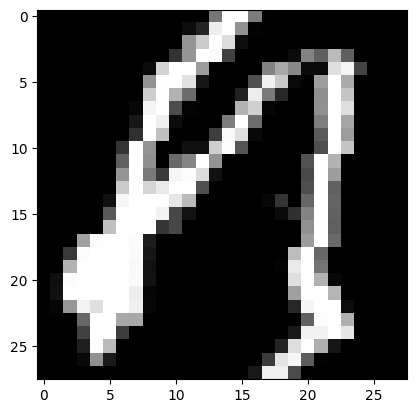

In [147]:
# Example
for xb, yb in train_data:
    plt.imshow(xb[0], cmap='gray')
    break

In [ ]:
train(epochs=epochs, loss=loss, optim=opt)

### 3. You can check the [Performance tuning](https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html) guide for many interesting tricks to speed-up computations; These include for our case:<br>(a) Optimizing the DataLoader<br>(b) Encapsulating `accuracy` in a `torch.no_grad` decorator<br>(c) Removing biases from the convolutional layers (since they are followed by a batch normalization layer)<br>(d) Enabling the "channels last" format<br>(e) Using the PyTorch JIT compiler.

In [36]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False, num_workers=8)

cudnn.benchmark = True

# Also added:
# - 'with torch.no_grad():' while evaluating our model on the test set
# - Added 'bias=False' to the conv2D Layers as explicited in documentation
# - Changed 'optim.zero_grad()' to:
#    for param in model.parameters():
#        param.grad = None
#   for zero-ing the gradients.
# - Added 'torch.backends.cudnn.benchmark = True'


In [163]:
train(epochs=epochs, loss=loss, optim=opt)

100%|██████████| 938/938 [00:18<00:00, 50.67it/s] 


Accuracy at epoch 0: 0.9592999815940857


100%|██████████| 938/938 [00:16<00:00, 57.16it/s] 


Accuracy at epoch 1: 0.9634000062942505


100%|██████████| 938/938 [00:14<00:00, 63.32it/s] 


Accuracy at epoch 2: 0.9605000019073486


100%|██████████| 938/938 [00:15<00:00, 59.66it/s] 


Accuracy at epoch 3: 0.9646999835968018


100%|██████████| 938/938 [00:15<00:00, 62.08it/s] 


Accuracy at epoch 4: 0.95660001039505


### 4. Can you add residual connections? It's very simple in this case, and it probably will not improve performance very much.


In [82]:
class SimpleCNN_Res(nn.Module):
    # Note: this is a variant of the LeNet-5 network.
    def __init__(self, *args, **kwargs):
        super().__init__()
        
        self.conv_block1 = nn.Sequential(
			nn.Conv2d(1, 16, 5, padding=2, bias=False), # 1 input channel, 16 output channels, 5x5 kernel size    
			nn.BatchNorm2d(16), # 16 = Number of features (Equals to the conv1 input channels)
			nn.ReLU(),
            nn.MaxPool2d(2) # 2 = Kernel Size
		) 
        self.conv_block2 = nn.Sequential(
			nn.Conv2d(16, 32, 5, padding=2, bias=False), # 16 input channel, 32 output channels, 5x5 kernel size
			nn.BatchNorm2d(32), # 32 = Number of features (Equals to the conv1 input channels)
			nn.ReLU(),
            nn.MaxPool2d(2) # 2 = Kernel Size
		) 

        self.fc1 = nn.Linear(32*7*7, 100) # Fully connected layer // Input, Output
        self.fc2 = nn.Linear(100, 10) # Fully connected layer // Input, Output
        self.drop = nn.Dropout(0.3) # Dropout layer with probability p = 0.3

    def forward(self, x):

        residual = x

        x = self.conv_block1(x) # First block
        residual = TF.resize(residual, x.shape[2])
        x += residual

        x = self.conv_block2(x) # Second block
        residual = TF.resize(residual, x.shape[2])
        x += residual

        x = x.reshape((-1, 32*7*7)) # Output shape: (batch_size, 32, 7, 7)

        # Alternative with global average pooling: x = x.mean([2, 3])
        x = self.fc1(x)
        x = F.relu(x)
        x = self.drop(x)
        x = self.fc2(x)
        return x

In [81]:
cnn = SimpleCNN_Res().to(device=device)
loss = nn.CrossEntropyLoss()
opt = torch.optim.Adam(cnn.parameters())
epochs = 4
train(epochs=epochs, loss=loss, optim=opt)

100%|██████████| 938/938 [00:35<00:00, 26.35it/s]


Accuracy at epoch 0: 0.8805000185966492


100%|██████████| 938/938 [00:36<00:00, 25.90it/s]


Accuracy at epoch 1: 0.9082000255584717


100%|██████████| 938/938 [00:35<00:00, 26.37it/s]


Accuracy at epoch 2: 0.9258999824523926


100%|██████████| 938/938 [00:32<00:00, 29.30it/s]


Accuracy at epoch 3: 0.9225000143051147


### 5. [Composer](https://github.com/mosaicml/composer) is an interesting library to apply transformations to speed up training; as an example, you can try adding CutMix to the data loading.

In [83]:
def trainComposer(epochs, loss_fn, optim):
  for epoch in range(epochs):
    
    # We put the CNN in training mode
    cnn.train()

    # We iterate over the train loader, taking batches of xb, yb.
    for xb, yb in tqdm.tqdm(train_loader):
      
      xb, yb = xb.to(device), yb.to(device) # Move them to the GPU

      X_cutmix, y_perm, area, _ = cf.cutmix_batch(xb, yb, alpha=0.2)

      X_cutmix = X_cutmix.to(device)
      y_perm = y_perm.to(device)

      y_hat = cnn(X_cutmix).to(device)
      
      loss = area * loss_fn(y_hat, yb) + (1 - area) * loss_fn(y_hat, y_perm)

      loss.backward() # We compute the gradients
      optim.step() # Parameters updated -> Single step optimization

      # We empty the gradients
      for param in cnn.parameters():
        param.grad = None
        
    with torch.no_grad():
      cnn.eval() # We put the CNN in evaluation mode for testing the accuracy over the test set
      print(f'Accuracy at epoch {epoch}: {accuracy(cnn, test_loader, device)}')

In [84]:
cnn = SimpleCNN_Res().to(device=device)
loss = nn.CrossEntropyLoss()
opt = torch.optim.Adam(cnn.parameters())
epochs = 4
trainComposer(epochs=epochs, loss_fn=loss, optim=opt)

100%|██████████| 938/938 [00:33<00:00, 27.86it/s]


Accuracy at epoch 0: 0.8284000158309937


100%|██████████| 938/938 [00:33<00:00, 28.22it/s]


Accuracy at epoch 1: 0.8672000169754028


100%|██████████| 938/938 [00:33<00:00, 28.15it/s]


Accuracy at epoch 2: 0.8709999918937683


100%|██████████| 938/938 [00:32<00:00, 28.51it/s]


Accuracy at epoch 3: 0.8989999890327454


### 6. Can you add early stopping? Note: you need a validation set + a check at the end of every epoch.


In [113]:
cnn = SimpleCNN().to(device=device)
loss = nn.CrossEntropyLoss()
opt = torch.optim.Adam(cnn.parameters())
epochs = 50
early_stopping = True
nepochs = 0

if(early_stopping):
  valid_losses = []
  avg_valid_losses = []
  train_losses = []
  avg_train_losses = []
  patience = 3
  i = 0
  best_loss = 1.0

for epoch in range(epochs):
  
  # We put the CNN in training mode
  cnn.train()

  # We iterate over the train loader, taking batches of xb, yb.
  for xb, yb in tqdm.tqdm(train_loader):
    
    xb, yb = xb.to(device), yb.to(device) # Move them to the GPU

    #opt.zero_grad() # We empty the gradients
    for param in cnn.parameters():
      param.grad = None
      
    ypred = cnn(xb) # Actual prediction of our model
    l = loss(ypred, yb) # We perform a Cross Entropy Loss between the real value and our prediction
    train_losses.append(l.item())
    l.backward() # We compute the gradients
    opt.step() # Parameters updated -> Single step optimization

  with torch.no_grad():
    cnn.eval() # We put the CNN in evaluation mode for testing the accuracy over the test set

    for xtest, ytest in tqdm.tqdm(test_loader):
        xtest, ytest = xtest.to(device), ytest.to(device) # Move them to the GPU
      
        ypred = cnn(xtest) # Actual prediction of our model
        l_test = loss(ypred, ytest) # We perform a Cross Entropy Loss between the real value and our prediction
        valid_losses.append(l_test.item())

  avg_t_loss = np.average(train_losses)
  avg_v_loss = np.average(valid_losses)

  print(F'Train Loss at epoch {epoch}: {avg_t_loss:.5f}')
  print(F'Val Loss at epoch {epoch}: {avg_v_loss:.5f}')
  avg_train_losses.append(avg_t_loss)
  avg_valid_losses.append(avg_v_loss)

  if avg_v_loss < best_loss:
    best_loss = avg_v_loss
    i = 0
  else:
    i += 1

  nepochs += 1
  
  if (i >= patience):
    print("Early stopping ...")
    print(F"Best loss was: {best_loss:.3f}")
    break
  else:  # At this point also save a snapshot of the current model
    train_losses = []
    valid_losses = []

100%|██████████| 157/157 [00:02<00:00, 72.39it/s]


Train Loss at epoch 0: 0.49097
Val Loss at epoch 0: 0.39283


100%|██████████| 157/157 [00:02<00:00, 74.05it/s]


Train Loss at epoch 1: 0.24910
Val Loss at epoch 1: 0.29397


100%|██████████| 157/157 [00:02<00:00, 73.58it/s]


Train Loss at epoch 2: 0.20475
Val Loss at epoch 2: 0.32368


100%|██████████| 157/157 [00:02<00:00, 73.09it/s]


Train Loss at epoch 3: 0.17806
Val Loss at epoch 3: 0.23818


100%|██████████| 157/157 [00:02<00:00, 74.04it/s]


Train Loss at epoch 4: 0.15680
Val Loss at epoch 4: 0.23995


100%|██████████| 157/157 [00:02<00:00, 72.61it/s]


Train Loss at epoch 5: 0.14421
Val Loss at epoch 5: 0.21977


100%|██████████| 157/157 [00:02<00:00, 72.80it/s]


Train Loss at epoch 6: 0.13386
Val Loss at epoch 6: 0.24014


100%|██████████| 157/157 [00:02<00:00, 71.64it/s]


Train Loss at epoch 7: 0.12466
Val Loss at epoch 7: 0.21236


100%|██████████| 157/157 [00:02<00:00, 71.83it/s]


Train Loss at epoch 8: 0.12150
Val Loss at epoch 8: 0.23113


100%|██████████| 157/157 [00:02<00:00, 73.21it/s]


Train Loss at epoch 9: 0.11213
Val Loss at epoch 9: 0.19348


100%|██████████| 157/157 [00:02<00:00, 73.81it/s]


Train Loss at epoch 10: 0.10727
Val Loss at epoch 10: 0.19848


100%|██████████| 157/157 [00:02<00:00, 72.23it/s]


Train Loss at epoch 11: 0.10106
Val Loss at epoch 11: 0.17671


100%|██████████| 157/157 [00:02<00:00, 73.57it/s]


Train Loss at epoch 12: 0.09878
Val Loss at epoch 12: 0.20659


100%|██████████| 157/157 [00:02<00:00, 73.96it/s]


Train Loss at epoch 13: 0.09495
Val Loss at epoch 13: 0.18157


100%|██████████| 157/157 [00:02<00:00, 72.28it/s]

Train Loss at epoch 14: 0.08986
Val Loss at epoch 14: 0.18283
Early stopping ...
Best loss was: 0.177


In [114]:
cnn.eval() # We put the CNN in evaluation mode for testing the accuracy over the test set
print(f'Final accuracy of the model: {accuracy(cnn, test_loader, device)*100:.3f}%')

Final accuracy of the model: 95.410%


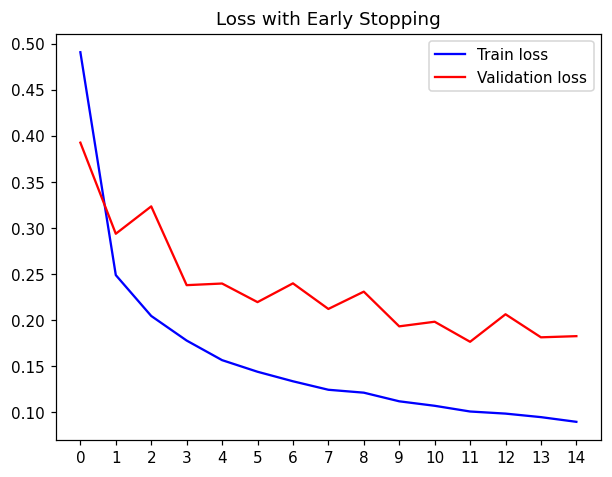

In [142]:
nepochs = 15
epochs = np.arange(0,nepochs,1)

plt.figure(dpi=110)
plt.title("Loss with Early Stopping")
#plt.xlabel('Epochs')
#plt.ylabel('Loss')
plt.plot(epochs, avg_train_losses, label="Train loss", c="blue")
plt.plot(epochs, avg_valid_losses, label="Validation loss", c="red")
plt.xticks(epochs)
plt.legend()
plt.show()

### 7. You can try [fine-tuning an existing model](https://pytorch.org/vision/stable/models.html) instead of building one from scratch.<br>In this case, you need to preprocess the images to an RGB format.

In [13]:
def accuracy(net, loader, device):
  # A function that aggregates the accuracy over all mini-batches in the loader.
  # See here for a quick-start on torchmetrics: https://torchmetrics.readthedocs.io/en/stable/pages/quickstart.html.
  acc = torchmetrics.Accuracy().to(device)
  for xb, yb in tqdm.tqdm(loader):
      xb = xb.repeat(1, 3, 1, 1) # RGB ;)
      xb, yb = xb.to(device), yb.to(device)
      ypred = net(xb)
      _ = acc(ypred, yb)
  return acc.compute()

In [16]:
num_classes = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

cnn = resnet34(weights=ResNet34_Weights.DEFAULT)
cnn.fc = nn.Linear(512, num_classes, bias=True)
cnn = cnn.to(device)
#print(cnn)

loss = nn.CrossEntropyLoss()
opt = torch.optim.Adam(cnn.parameters())
epochs = 50

early_stopping = True
nepochs = 0

if(early_stopping):
  accuracies = []
  patience = 3
  i = 0
  best_acc = 0.0

# Example
#for xb, yb in train_data:
    #xb = xb.repeat(1, 3, 1, 1)
    #xb = xb.squeeze()
    #pilimg = TF.to_pil_image(xb)
    #plt.imshow(pilimg)
    #break

# --------- TRAINING ---------- #
for epoch in range(epochs):
    # We put the CNN in training mode
    cnn.train()

    # We iterate over the train loader, taking batches of xb, yb.
    for xb, yb in tqdm.tqdm(train_loader):
        xb = xb.repeat(1, 3, 1, 1) # RGB ;)
        xb, yb = xb.to(device), yb.to(device) # Move them to the GPU

        #optim.zero_grad() # We empty the gradients
        for param in cnn.parameters():
            param.grad = None
        
        ypred = cnn(xb) # Actual prediction of our model
        l = loss(ypred, yb) # We perform a Cross Entropy Loss between the real value and our prediction

        l.backward() # We compute the gradients
        opt.step() # Parameters updated -> Single step optimization

    with torch.no_grad():
        cnn.eval() # We put the CNN in evaluation mode for testing the accuracy over the test set
        acc = accuracy(cnn, test_loader, device)
        accuracies.append(acc.detach().cpu().numpy())
        print(f'Accuracy at epoch {epoch}: {acc*100:.3f}')

    if acc > best_acc:
        best_acc = acc
        i = 0
    else:
        i += 1

    nepochs += 1
    
    if (i >= patience):
        print("Early stopping ...")
        print(F"Best accuracy was: {best_acc*100:.3f}")
        break
    else:  # At this point also save a snapshot of the current model
        continue

100%|██████████| 157/157 [00:03<00:00, 44.76it/s]


Accuracy at epoch 0: 92.270


100%|██████████| 157/157 [00:03<00:00, 42.88it/s]


Accuracy at epoch 1: 94.010


100%|██████████| 157/157 [00:03<00:00, 47.68it/s]


Accuracy at epoch 2: 96.010


100%|██████████| 157/157 [00:03<00:00, 44.70it/s]


Accuracy at epoch 3: 94.540


100%|██████████| 157/157 [00:03<00:00, 45.95it/s]


Accuracy at epoch 4: 96.310


100%|██████████| 157/157 [00:03<00:00, 44.44it/s]


Accuracy at epoch 5: 96.860


100%|██████████| 157/157 [00:03<00:00, 49.65it/s]


Accuracy at epoch 6: 96.610


100%|██████████| 157/157 [00:03<00:00, 45.89it/s]


Accuracy at epoch 7: 96.090


100%|██████████| 157/157 [00:03<00:00, 45.49it/s]


Accuracy at epoch 8: 96.890


100%|██████████| 157/157 [00:03<00:00, 46.91it/s]


Accuracy at epoch 9: 97.280


100%|██████████| 157/157 [00:04<00:00, 36.74it/s]


Accuracy at epoch 10: 97.290


100%|██████████| 157/157 [00:03<00:00, 45.32it/s]


Accuracy at epoch 11: 96.950


100%|██████████| 157/157 [00:03<00:00, 45.87it/s]


Accuracy at epoch 12: 97.030


100%|██████████| 157/157 [00:03<00:00, 47.83it/s]


Accuracy at epoch 13: 97.410


100%|██████████| 157/157 [00:03<00:00, 45.47it/s]


Accuracy at epoch 14: 97.630


100%|██████████| 157/157 [00:03<00:00, 46.88it/s]


Accuracy at epoch 15: 97.520


100%|██████████| 157/157 [00:03<00:00, 45.54it/s]


Accuracy at epoch 16: 97.070


100%|██████████| 157/157 [00:03<00:00, 46.91it/s]

Accuracy at epoch 17: 97.360
Early stopping ...
Best accuracy was: 97.630


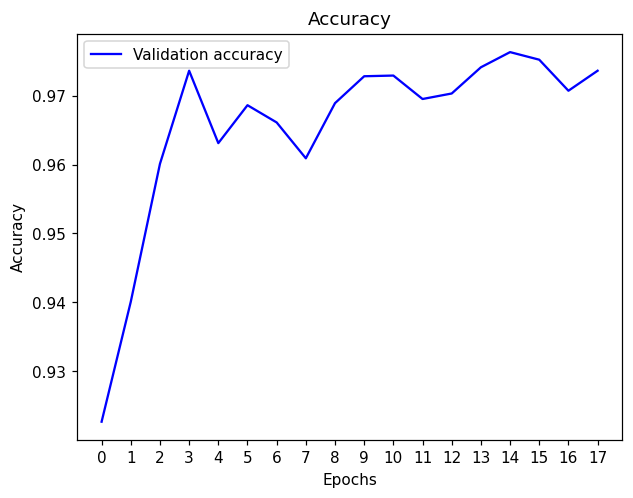

In [30]:
epochs = np.arange(0,nepochs,1)

# for idx in range(len(accuracies)):
#    var = accuracies[idx]
#    var = var.detach().cpu().numpy()
#    accuracies[idx] = var

plt.figure(dpi=110)
plt.title("Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, accuracies, label="Validation accuracy", c="blue")
plt.xticks(epochs)
plt.legend()
plt.show()